# Necessary Libraries

In [1]:
pip install evaluate datasets rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a5ae1f0058a793fd893caeeed59832ea8969d87d03addc0bcc92696607cf1f8c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's d

In [2]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import (AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling)
import evaluate
from sklearn.model_selection import train_test_split
from huggingface_hub import login
import numpy as np

# HuggingFace notebook login

In [3]:
login(token = "HuggingFace_token")

# Data pre-processing

In [4]:
df = pd.read_csv("mahabharat_1-2.csv")

def create_prompt(row, prompt_split_ratio = 0.4):
    """
    For each record:
      - Combines the contextual columns (Parv, Key Event, Section)
      - Splits the Summary into a prompt portion and a continuation portion.
    Returns:
      - final_prompt: The combined prompt (with contextual info + first part of the story)
      - target_story: The continuation that the model should generate.
    """
    # Extract and clean the columns
    parv = str(row["Parv"]).strip()
    key_event = str(row["Key Event"]).strip()
    section = str(row["Section"]).strip()
    summary = str(row["Summary"]).strip()

    # Create a header with contextual information
    header = f"Parv: {parv}\nKey Event: {key_event}\nSection: {section}\nStory:"

    # Split the Summary into words and determine the split index
    words = summary.split()
    prompt_word_count = int(len(words) * prompt_split_ratio)

    # Ensure there is enough text to split; if not, use the whole summary as prompt (empty target)
    if prompt_word_count == 0 or prompt_word_count >= len(words):
        prompt_story = summary
        target_story = ""
    else:
        prompt_story = " ".join(words[:prompt_word_count])
        target_story = " ".join(words[prompt_word_count:])

    # Combine header and prompt portion to form the final prompt
    final_prompt = f"{header} {prompt_story}"

    return final_prompt, target_story

# Process each record to create prompt/continuation pairs.
prompts, targets = [], []

for idx, row in df.iterrows():
    prompt, target = create_prompt(row, prompt_split_ratio = 0.4)
    prompts.append(prompt)
    targets.append(target)

# Create a DataFrame with our training pairs.
# For causal language modeling, we will train on the concatenation of prompt and continuation.
data_pairs = pd.DataFrame({"prompt": prompts, "target": targets})
data_pairs["text"] = data_pairs["prompt"] + " " + data_pairs["target"]

# -------------------------------
# Create a Hugging Face Dataset and Fixed Train-Test Split
# -------------------------------
# Convert the DataFrame to a Hugging Face Dataset.
# (Note: For training the model we use the concatenated 'text' field.)
dataset = Dataset.from_pandas(data_pairs)

# Use a fixed split: 90% for training and 10% for validation.
dataset = dataset.train_test_split(test_size = 0.1, seed = 42)

## Tokenization

In [5]:
# Load the GPT Neo 125M tokenizer.
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define a maximum sequence length.
max_length = 512

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation = True, max_length = max_length, padding = "max_length")

# Tokenize the dataset (remove extra columns).
tokenized_datasets = dataset.map(tokenize_function, batched = True, remove_columns = ["prompt", "target", "text"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

# Training the LLM

In [6]:
# Create the data collator for causal language modeling.
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm = False)

# Load the pre-trained GPT Neo 125M model.
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
training_args = TrainingArguments(
    output_dir = "./gptneo_mahabharata",
    overwrite_output_dir = True,
    num_train_epochs = 5,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    logging_steps = 10,
    learning_rate = 5e-5,
    weight_decay = 0.01,
    save_total_limit = 2,
    fp16 = True,
    report_to = []  # Disable wandb logging
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    data_collator = data_collator
)

print("Starting training...")
trainer.train()
print("Evaluating on validation set...")
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


Epoch,Training Loss,Validation Loss
1,3.248200,3.034781
2,2.972500,2.970018
3,2.484100,2.944903
4,2.355900,2.947106
5,2.280800,2.949233


Evaluating on validation set...


Evaluation Results: {'eval_loss': 2.949233293533325, 'eval_runtime': 0.1286, 'eval_samples_per_second': 23.337, 'eval_steps_per_second': 15.558, 'epoch': 5.0}


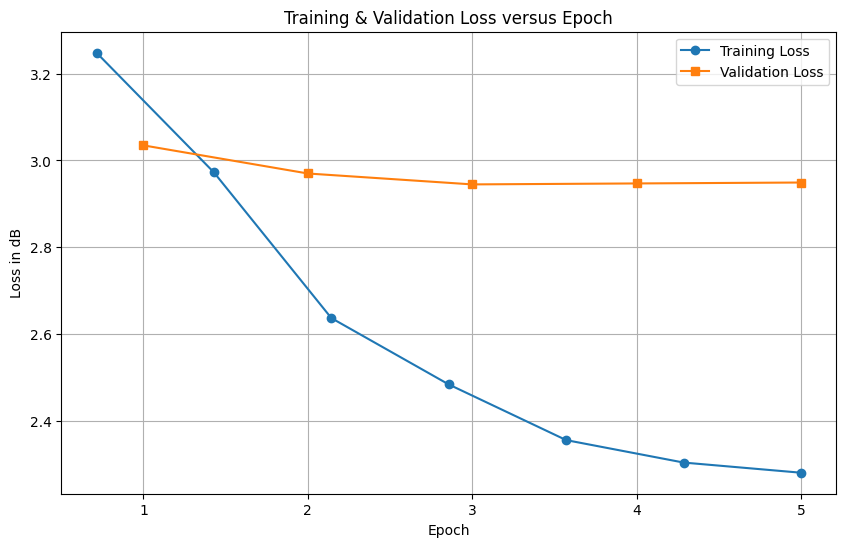

In [7]:
# Extract the log history from the trainer after training
log_history = trainer.state.log_history

# Initialize lists to store epoch numbers and losses.
# Note: The Trainer might log multiple entries per epoch (e.g., logging at each step),
# so here we filter for logs that include the epoch number.
train_epochs = []
train_losses = []
eval_epochs = []
eval_losses = []

# Iterate over the log history and collect losses.
for log in log_history:
    # For training loss logs (logged every few steps)
    if "loss" in log and "epoch" in log:
        # You might get multiple log entries per epoch. Here, we simply append all of them.
        train_epochs.append(log["epoch"])
        train_losses.append(log["loss"])
    # For evaluation loss logs (typically logged at the end of each epoch)
    if "eval_loss" in log and "epoch" in log:
        eval_epochs.append(log["epoch"])
        eval_losses.append(log["eval_loss"])


def average_losses(epochs, losses):
    epoch_dict = {}

    for epoch, loss in zip(epochs, losses):
        epoch_dict.setdefault(epoch, []).append(loss)
    avg_epochs = sorted(epoch_dict.keys())
    avg_losses = [np.mean(epoch_dict[e]) for e in avg_epochs]
    return avg_epochs, avg_losses

avg_train_epochs, avg_train_losses = average_losses(train_epochs, train_losses)
avg_eval_epochs, avg_eval_losses = average_losses(eval_epochs, eval_losses)
# Plot the averaged training and evaluation losses versus epoch.
plt.figure(figsize = (10, 6))
plt.plot(avg_train_epochs, avg_train_losses, label = "Training Loss", marker = "o")
plt.plot(avg_eval_epochs, avg_eval_losses, label = "Validation Loss", marker = "s")
plt.xlabel("Epoch")
plt.ylabel("Loss in dB")
plt.title("Training & Validation Loss versus Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Model Inference and ROUGE Evaluation

In [8]:
# For ROUGE evaluation, we use the original data_pairs DataFrame.
# Create a train-test split (using sklearn) from the original data_pairs DataFrame.
train_df, test_df = train_test_split(data_pairs, test_size = 0.1, random_state = 42)
# Choose one test example.
example = test_df.iloc[0]
example_prompt = example["prompt"]
ground_truth = example["target"]
# Tokenize the example prompt and move tensors to the correct device.
encoded_prompt = tokenizer(example_prompt, return_tensors = "pt").to(model.device)
input_ids = encoded_prompt.input_ids
attention_mask = encoded_prompt.attention_mask
# Generate continuation using max_new_tokens instead of max_length.
generated_output = model.generate(
    input_ids,
    attention_mask = attention_mask,  # Ensures proper handling of padding.
    max_new_tokens = 200,             # Generate 200 new tokens in addition to the input.
    do_sample = True,
    temperature = 0.8,
    top_p = 0.95,
    no_repeat_ngram_size = 2,
    return_dict_in_generate = True,
    output_scores = False
)
# Decode the full generated sequence.
generated_text_full = tokenizer.decode(generated_output.sequences[0], skip_special_tokens = True)

# Extract the generated continuation by removing the prompt.
if generated_text_full.startswith(example_prompt):
    generated_continuation = generated_text_full[len(example_prompt):].strip()
else:
    generated_continuation = generated_text_full.strip()

print("\n=== Test Example Inference ===")
print("Prompt:\n", example_prompt)
print("\nGround Truth Continuation:\n", ground_truth)
print("\nGenerated Continuation:\n", generated_continuation)
# Load the ROUGE metric using the evaluate library.
rouge_metric = evaluate.load("rouge")
# Compute ROUGE scores comparing the generated continuation with the ground truth.
rouge_scores = rouge_metric.compute(predictions = [generated_continuation], references = [ground_truth])
print("\nROUGE Scores:")
print(rouge_scores)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.



=== Test Example Inference ===
Prompt:
 Parv: Sabha Parva
Key Event: The Gambling Match
Section: 28
Story: The Pandavas soon arrived at Hastinapura, the Kuru capital, where they were offered a superficial welcome by Dhritarastra and supplied rooms that were beautifully furnished. They spent the night in those apartments, and the next they were taken by Dhritarastra to the new imperial court at Jayanta. Following them were Duryodhana and his one hundred brothers, Shakuni and the other members of the Kuru race such as Bhishma, Somadatta and Bhurishravas. The Pandavas were shown the assembly hall, and out of courtesy the Pandavas expressed appreciation for the beauty of the royal assembly court. However, it did not measure up to the beauty of the imperial court built by the demon Maya. Duryodhana and his followers were indifferent to the assembly house; their minds were fixed on the gambling match. After the hall had been inspected, Shakuni suggested that they sit down and play a game of


ROUGE Scores:
{'rouge1': 0.19327006039689387, 'rouge2': 0.03630077787381158, 'rougeL': 0.091458153580673, 'rougeLsum': 0.091458153580673}


# Push the Model and Tokenizer to Hugging Face Hub

In [9]:
model.push_to_hub("Samurai719214/gptneo-mythology-storyteller")
tokenizer.push_to_hub("Samurai719214/gptneo-mythology-storyteller")

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Samurai719214/gptneo-mythology-storyteller/commit/f116da2b24543dfcca0e3f6aa877f622bca83b5c', commit_message='Upload tokenizer', commit_description='', oid='f116da2b24543dfcca0e3f6aa877f622bca83b5c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Samurai719214/gptneo-mythology-storyteller', endpoint='https://huggingface.co', repo_type='model', repo_id='Samurai719214/gptneo-mythology-storyteller'), pr_revision=None, pr_num=None)